## 전통적 시계열 모델링

### 유통매장 수요량 예측


- 발주 최적화를 위한 수요량 예측 : 1일후의 판매량을 예측

### 1. 환경준비

In [1]:
# 라이브러리 로딩
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as spst
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import *
from sklearn.model_selection import train_test_split

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

함수 생성

In [2]:
# 결과 시각화
def plot_model_result(y_train, y_val, pred) :
    pred = pd.Series(pred, index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

In [3]:
# 잔차분석
def residual_diag(residuals, lags = 30) :
    print('* 정규성 검정(> 0.05) : ', round(spst.shapiro(residuals)[1],5))
    print('* 정상성 검정(< 0.05) : ', round(sm.tsa.stattools.adfuller(residuals)[1],5))
    print('* 자기상관성 확인(ACF, PACF)')
    fig,ax = plt.subplots(1,2, figsize = (15,5))
    plot_acf(residuals, lags = lags, ax = ax[0])
    plot_pacf(residuals, lags = lags, ax = ax[1])
    plt.show()

In [4]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/retail_demand2.csv'
data = pd.read_csv(path)
data = data.loc[(data['date']>= '2013-06-01') & (data['date']< '2015-03-01')].reset_index(drop = True)
data.head(10)

,date,item,sales,tot_sales,comp_sales
0,2013-06-01,28,124,1016,80
1,2013-06-02,28,139,1019,93
2,2013-06-03,28,77,676,65
3,2013-06-04,28,93,764,80
4,2013-06-05,28,117,818,80
5,2013-06-06,28,112,881,71
6,2013-06-07,28,127,929,81
7,2013-06-08,28,105,925,78
8,2013-06-09,28,129,998,95
9,2013-06-10,28,103,710,74


* 변수 설명

    * date : 날짜
    * item : 상품코드 (여기서는 한가지 상품만 있음)
    * sales : A유통회사 a 매장 판매량 ==> target
    * tot_sales : A유통회사 전체 판매량
    * comp_sales : 인근에 위치한 B유통회사 b 매장 판매량

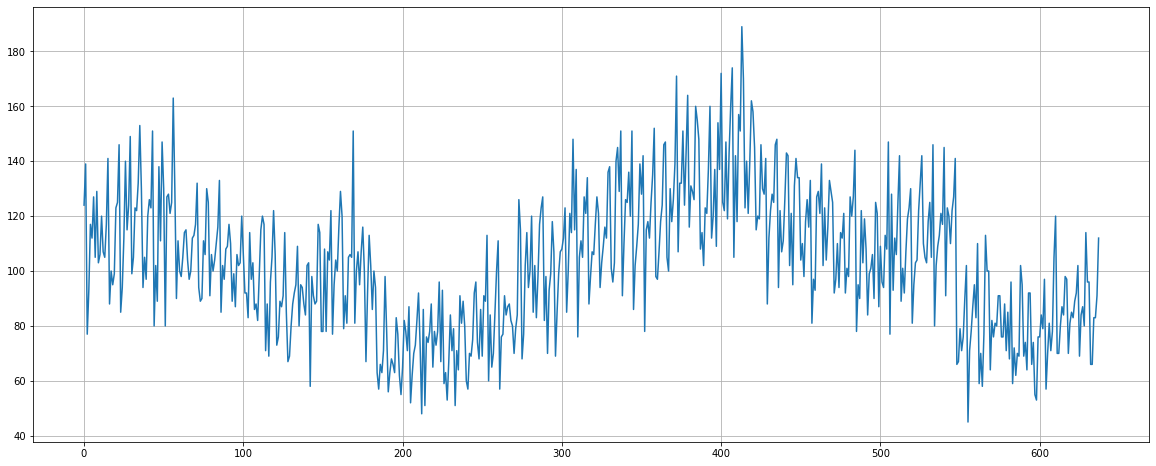

In [5]:
plt.figure(figsize = (20,8))
plt.plot(data['sales'])
plt.grid()
plt.show()

### 2. 기본 전처리

In [6]:
# y만들기 (1일 후 수요량 예측)
data['y'] = data['sales'].shift(-1)
display(data.head())
display(data.tail())

,date,item,sales,tot_sales,comp_sales,y
0,2013-06-01,28,124,1016,80,139.0
1,2013-06-02,28,139,1019,93,77.0
2,2013-06-03,28,77,676,65,93.0
3,2013-06-04,28,93,764,80,117.0
4,2013-06-05,28,117,818,80,112.0


,date,item,sales,tot_sales,comp_sales,y
633,2015-02-24,28,66,603,71,83.0
634,2015-02-25,28,83,622,61,83.0
635,2015-02-26,28,83,611,48,91.0
636,2015-02-27,28,91,696,74,112.0
637,2015-02-28,28,112,774,77,NaN


In [7]:
# 제일 마지막 행은 삭제
data.dropna(axis = 0, inplace = True)
data.tail()

,date,item,sales,tot_sales,comp_sales,y
632,2015-02-23,28,66,488,43,66.0
633,2015-02-24,28,66,603,71,83.0
634,2015-02-25,28,83,622,61,83.0
635,2015-02-26,28,83,611,48,91.0
636,2015-02-27,28,91,696,74,112.0


In [8]:
# 데이터 분할
target = 'y'
x = data.drop([target, 'date'], axis = 1) #제거할 때, date도 제거
y = data.loc[:, target]

train, val 분할

- 시계열 데이터이기 때문에 shuffle하지 않음.
- k-fold cross validation for Time Series : TimeSeriesSplit

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 30, shuffle = False)

### 3. 모델링1 : ARIMA

* 정규성 검정(> 0.05) :  0.00746
* 정상성 검정(< 0.05) :  0.54662
* 자기상관성 확인(ACF, PACF)


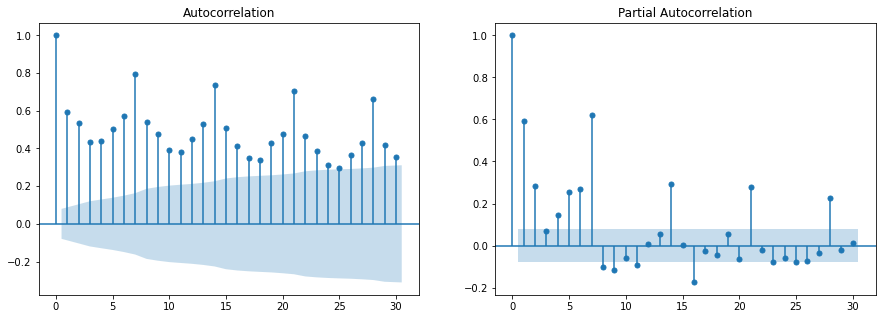

In [10]:
# y값 살펴보기
residual_diag(y_train, lags=30)

모델링 : 초기모델

- p,d,q값 정하기.
- AR의 p차수와 MA의 q차수 모두 값이 필요.

In [11]:
# 학습
model = sm.tsa.SARIMAX(y_train, order=(1,0,1)).fit()

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  1e-05
* 자기상관성 확인(ACF, PACF)


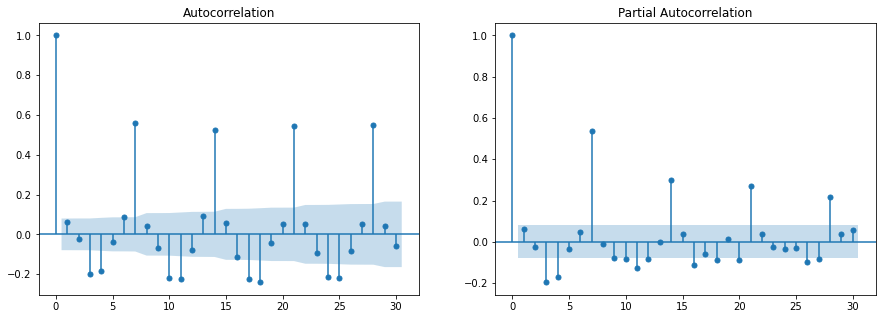

In [12]:
# 평가 (잔차진단)
# train에 대한 pred 값
residuals = model.resid # y_train과 pred의 차이 -> train 데이터 이후에 대한 pred 값
residual_diag(residuals)

AIC

- 선형 모델에서의 적합도와 feature가 과도하게 늘어나는 것을 방지.
- 값이 작을수록 좋은 모델.
- 공식 : 𝐴𝐼𝐶=−2 ln⁡(𝐿)+2𝑘 ➡ - 모델의 적합도 + 변수의 갯수

In [13]:
# 평가 (AIC)
print('model AIC :', model.aic)

model AIC : 5246.488864351655


In [14]:
# Validation
pred = model.forecast(30)
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE :', mean_absolute_percentage_error(y_val, pred))

MAE : 15.265834521749838
MAPE : 0.1613604151880646


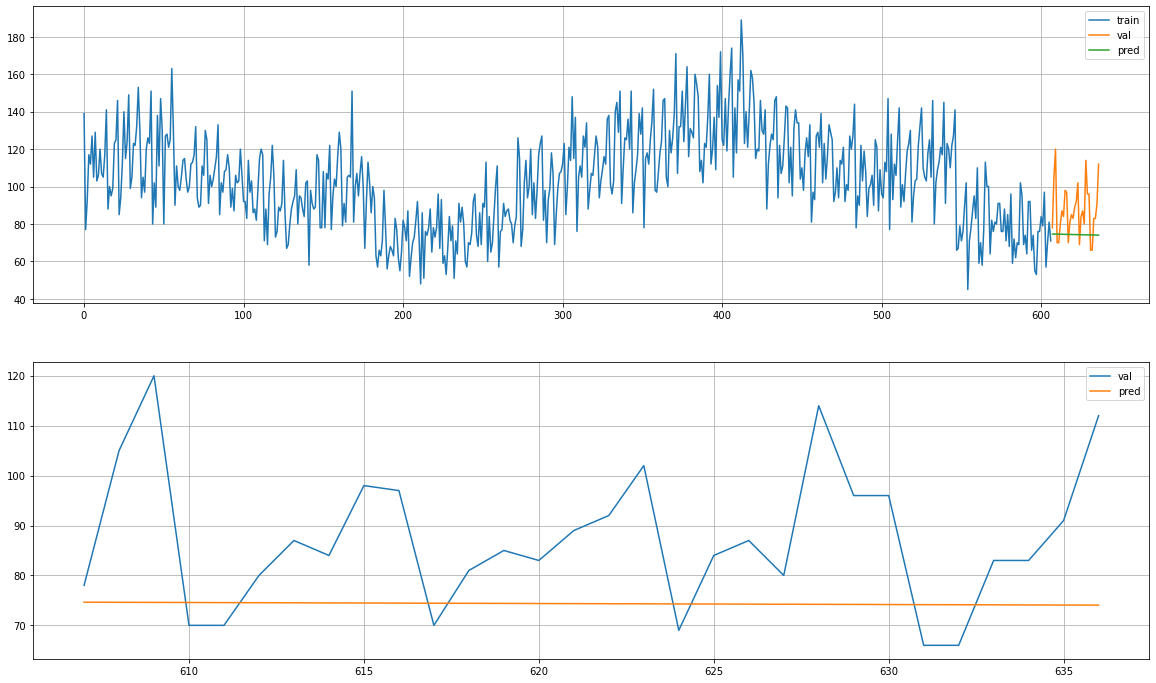

In [15]:
# 시각화
plot_model_result(y_train, y_val, pred)

In [16]:
from itertools import product

In [17]:
# 하이퍼파라미터 튜닝
p = [1,2,3,4]
q = [1,2,3,4]
d = [1]
iter = list(product(p,d,q))
iter

[(1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3),
 (3, 1, 4),
 (4, 1, 1),
 (4, 1, 2),
 (4, 1, 3),
 (4, 1, 4)]

In [18]:
# 튜닝
mae, aic = [],[]
for i in iter :
    model_fit = sm.tsa.SARIMAX(y_train, order=(i[0],i[1],i[2])).fit()
    pred = model_fit.forecast(30)
    mae.append( mean_absolute_error(y_val, pred))
    aic.append(model_fit.aic)
    print(i)

(1, 1, 1)
(1, 1, 2)
(1, 1, 3)
(1, 1, 4)
(2, 1, 1)
(2, 1, 2)
(2, 1, 3)
(2, 1, 4)
(3, 1, 1)
(3, 1, 2)
(3, 1, 3)
(3, 1, 4)
(4, 1, 1)
(4, 1, 2)
(4, 1, 3)
(4, 1, 4)


In [19]:
# 평가 (잔차진단)
result = pd.DataFrame({'params(p,d,q)' : iter, 'mae' : mae, 'aic' : aic})

display(result.loc[result['mae'] == result.mae.min()])
display(result.loc[result['aic'] == result.aic.min()])

,"params(p,d,q)",mae,aic
15,"(4, 1, 4)",11.14623,4981.713678


,"params(p,d,q)",mae,aic
15,"(4, 1, 4)",11.14623,4981.713678


In [20]:
model_t = sm.tsa.SARIMAX(y_train, order=(4,1,4)).fit()

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


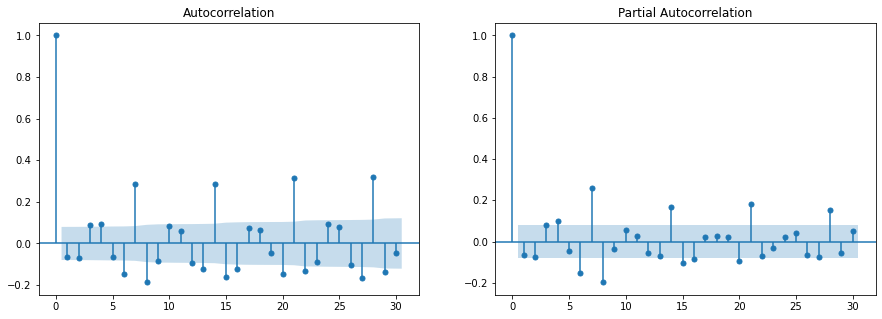

In [21]:
residuals = model_t.resid
residual_diag(residuals)

- 7일 주기 (Cycle)
    - 계절성이 있음.
    - ARIMA는 이를 잘 해결할 수 없음 -> SARIMA

In [22]:
# AIC
print('model_t AIC :', model_t.aic)

model_t AIC : 4981.7136779290995


In [23]:
# Validation
pred = model_t.forecast(30)
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))

MAE : 11.146229935280152
MAPE: 0.12000050230602304


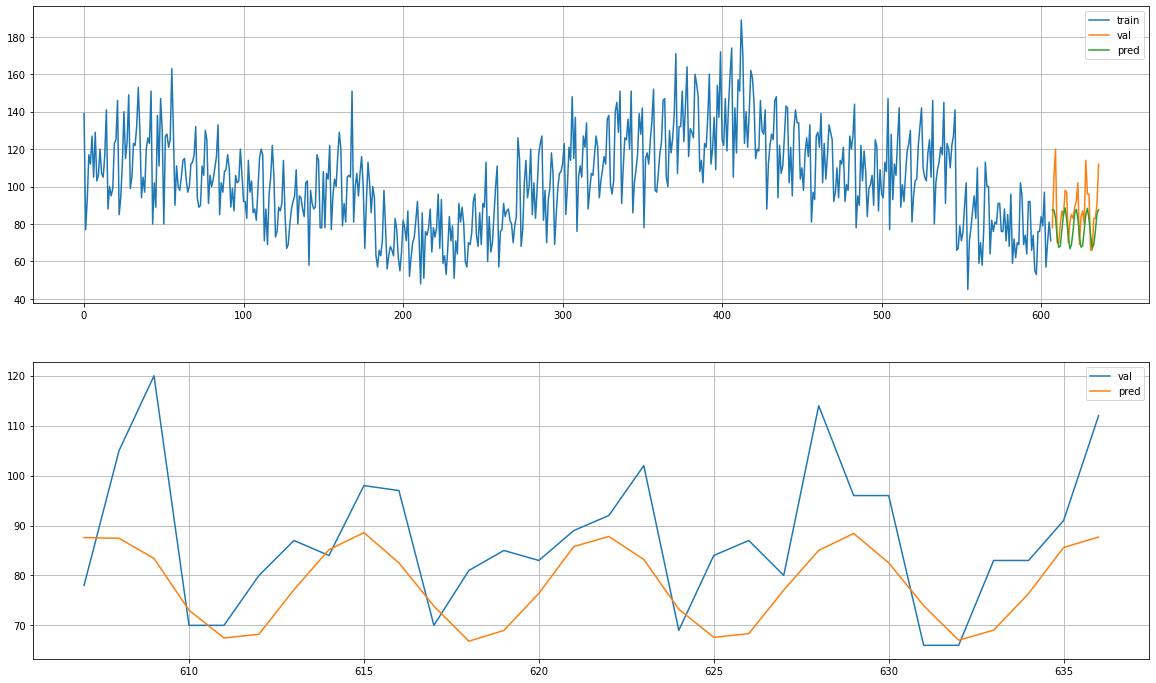

In [24]:
plot_model_result(y_train, y_val, pred)

### 4. 모델링2 : SARIMA

In [25]:
# 학습 (P, D, Q)
model_sarima = sm.tsa.SARIMAX(y_train, order=(4,1,4), seasonal_order=(1,1,1,7)).fit()

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


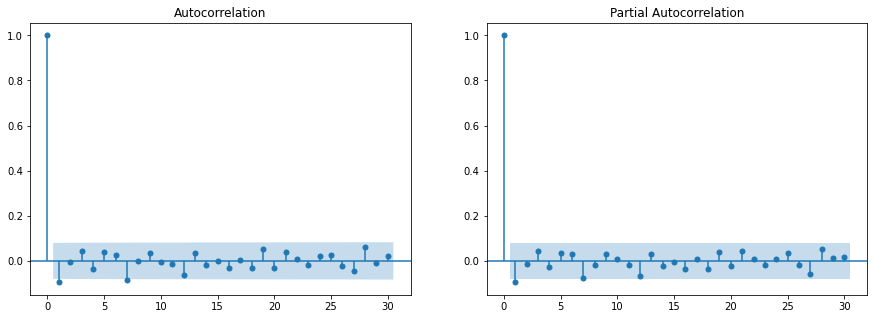

In [26]:
# 평가 (잔차진단)
residuals = model_sarima.resid
residual_diag(residuals)

In [27]:
# AIC
print('model_sarima :', model_sarima.aic)

model_sarima : 4677.8480958378495


In [28]:
# Validation
pred = model_sarima.forecast(30)
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE :', mean_absolute_percentage_error(y_val, pred))

MAE : 11.22324676572775
MAPE : 0.12623879677272665


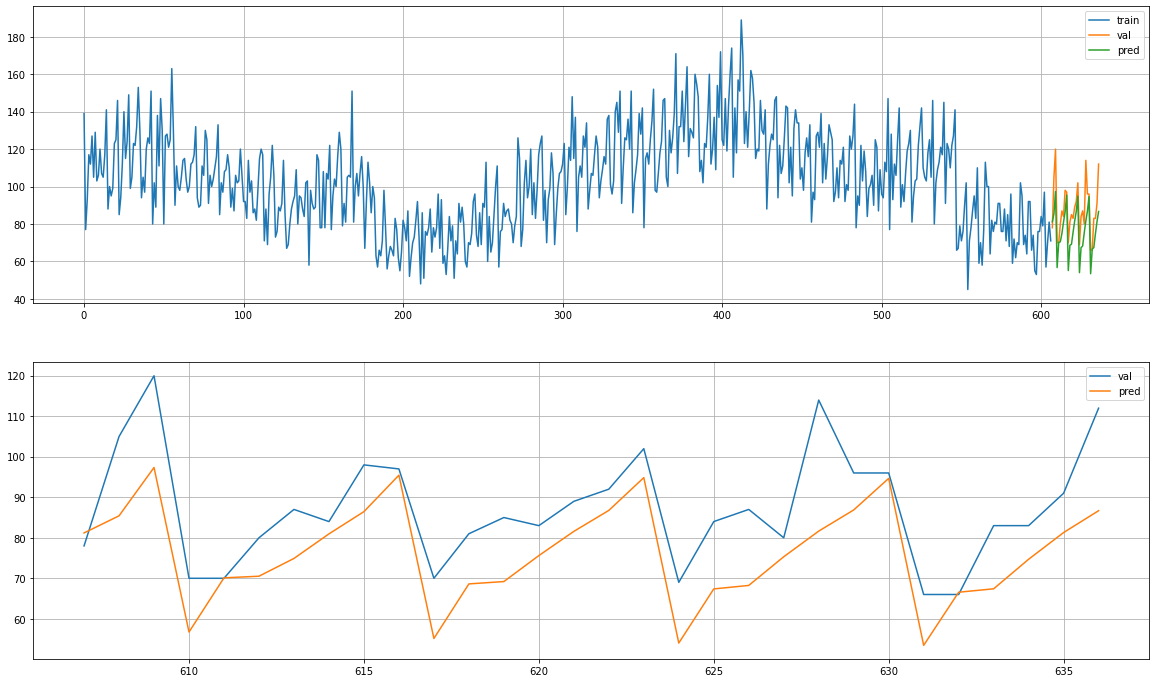

In [29]:
# 시각화
plot_model_result(y_train, y_val, pred)

In [30]:
# 하이퍼파라미터 튜닝
P = [1,2,3]
Q = [1,2,3]
D = [1]
mae, aic = [],[]
iter = list(product(P,D,Q))

for i in iter :
    model_fit = sm.tsa.SARIMAX(y_train, order=(4,1,4), seasonal_order=(i[0],i[1],i[2],7)).fit()
    pred = model_fit.forecast(30)
    mae.append( mean_absolute_error(y_val, pred))
    aic.append(model_fit.aic)
    print(i)

(1, 1, 1)
(1, 1, 2)
(1, 1, 3)
(2, 1, 1)
(2, 1, 2)
(2, 1, 3)
(3, 1, 1)
(3, 1, 2)
(3, 1, 3)


In [31]:
result = pd.DataFrame({'params(P,D,Q)' : iter, 'mae' : mae, 'aic':aic})

display(result.loc[result['mae'] == result.mae.min()])
display(result.loc[result['aic'] == result.aic.min()])

,"params(P,D,Q)",mae,aic
8,"(3, 1, 3)",10.364058,4687.043886


,"params(P,D,Q)",mae,aic
0,"(1, 1, 1)",11.223247,4677.848096


In [32]:
# 가장 성능이 좋은 P, D, Q 값으로 모델을 생성.

model_sarima_t = sm.tsa.SARIMAX(y_train, order=(4,1,4), seasonal_order=(3,1,3,7)).fit()

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


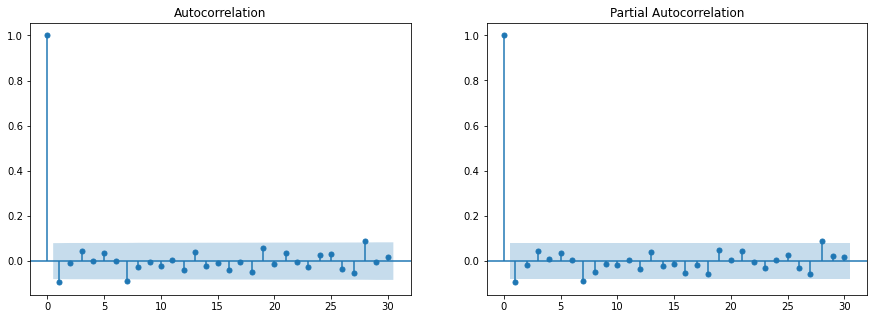

In [33]:
# 평가 (잔차진단)
residuals = model_sarima_t.resid
residual_diag(residuals)

In [34]:
# AIC
print('model_sarima_t :', model_sarima_t.aic)

model_sarima_t : 4687.043885762135


In [35]:
# Validation
pred = model_sarima_t.forecast(30)
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))

MAE : 10.364057590118147
MAPE: 0.11717397833265668


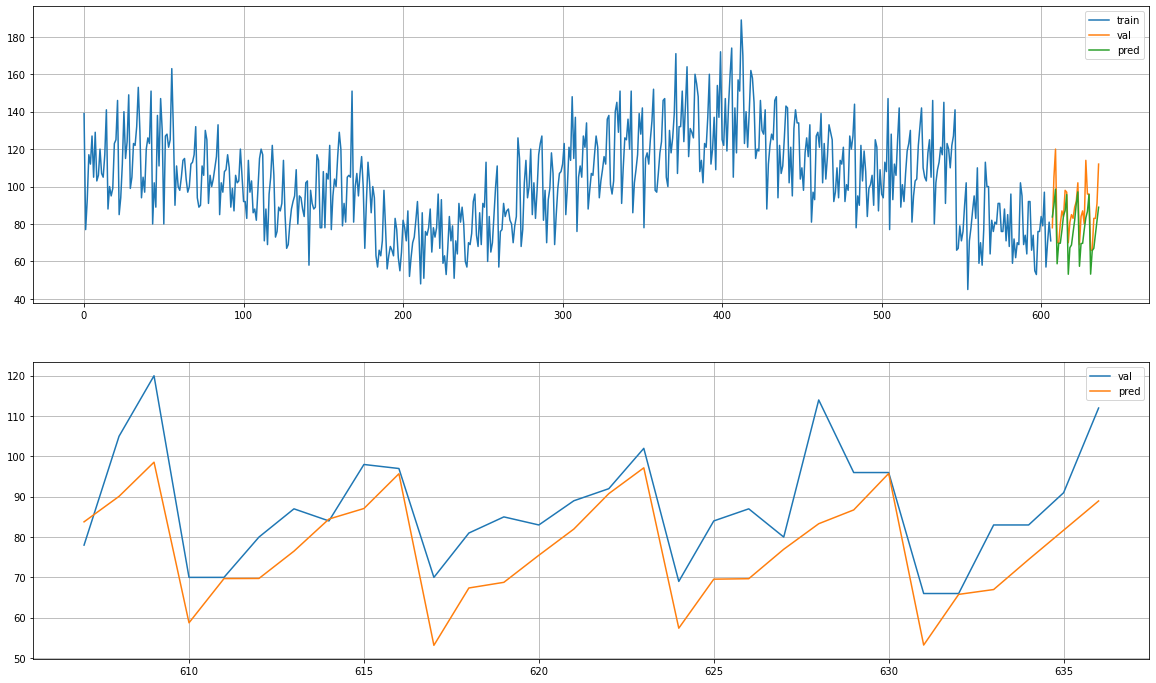

In [36]:
plot_model_result(y_train, y_val, pred)

### 5. 모델링3 : SARIMAX

In [37]:
m3_1 = sm.tsa.SARIMAX(y_train, order=(4,1,4), seasonal_order=(3,1,3,7), exog=x_train).fit()

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


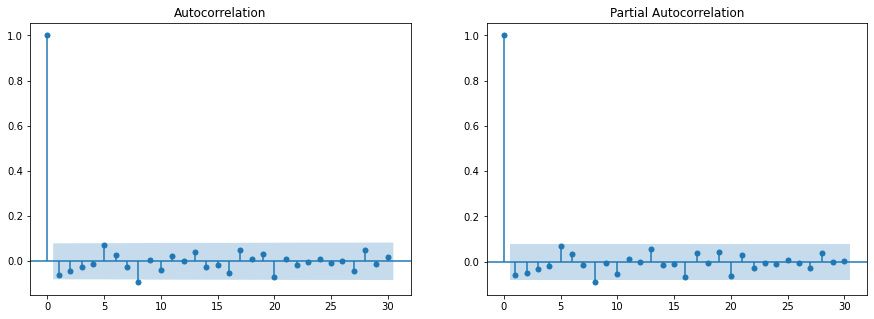

In [38]:
# 평가 (잔차진단)
residuals = m3_1.resid 
residual_diag(residuals)

In [39]:
# AIC
print('m3_1 AIC :', m3_1.aic)

m3_1 AIC : 4648.015692124491


In [40]:
# Validation
pred = m3_1.forecast(30, exog=x_val)
print('MAE :', mean_absolute_error(y_val, pred)) 
print('MAPE:', mean_absolute_percentage_error(y_val, pred))

MAE : 7.4221171347416695
MAPE: 0.08401731762582142


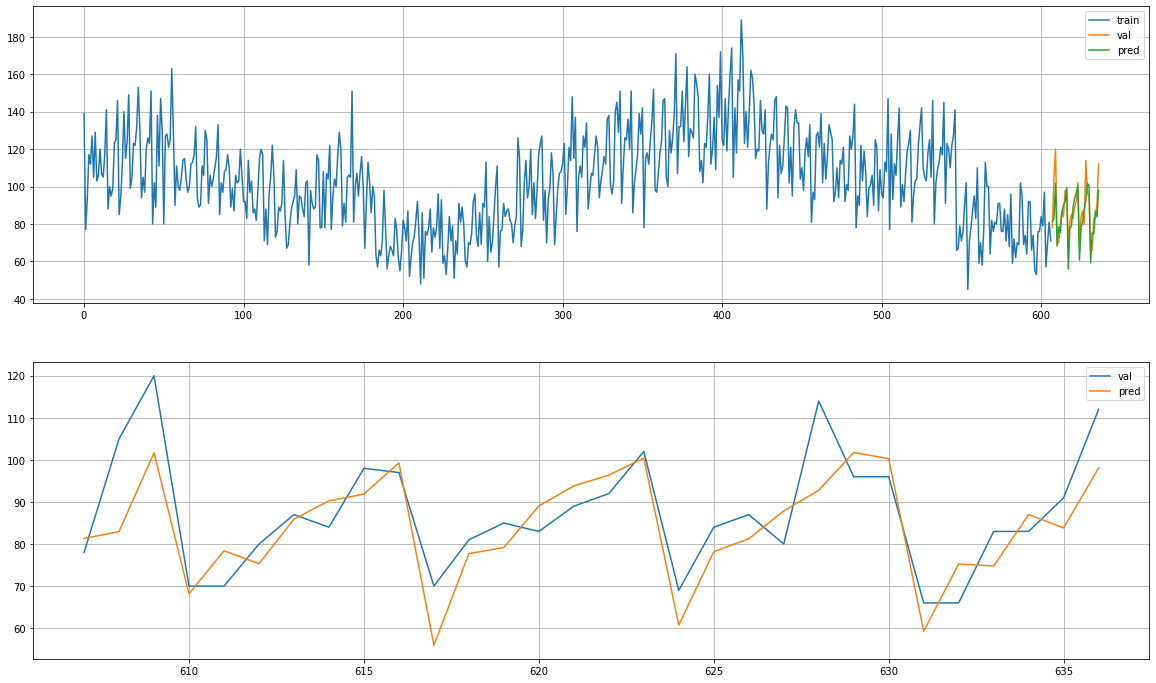

In [41]:
# 시각화
plot_model_result(y_train, y_val, pred)